# Chirp frame generator for "chirp" project

June 3, 2018

Reference: https://dzone.com/articles/sound-synthesis-numpy

In [105]:
%matplotlib inline

from numpy import linspace, sin, cos, pi, int16, append
from scipy.io.wavfile import write
from scipy.signal import spectrogram, welch
import matplotlib.pyplot as plt

In [77]:
SAMPLING_RATE = 100000  # Hz
TQ = 0.0205 # Time quantum in sec
TQ_half = TQ / 2.0
AMPLITUDE = 20000

## Tone synthesis

In [78]:
def chirp(f1, f2, length, amp=1, rate=SAMPLING_RATE, updown="up"):
    t = linspace(0, length, int(length * rate))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    data = sin(2 * pi * freq * t) * amp
    return data.astype(int16) # two byte integers

In [79]:
F1 = 17000
F2 = 18000

def tq_half(level, updown="up"):
    tone = None
    if level >= 1:
        tone = chirp(F1, F2, TQ_half, amp=AMPLITUDE, updown=updown)
    else:
        tone = chirp(0, 0, TQ_half, amp=AMPLITUDE, updown=updown)
    tone = append(tone, tone)
    return tone

HIGH = 1
LOW = 0

TQ_HIGH = tq_half(HIGH)
TQ_LOW = tq_half(LOW)

In [80]:
FRAME_FIELD_LENGTH = {"START_OF_FRAME": 3, "BITS": 2}
TRAILER = 8

def field(level, length):
    tone = None
    tone_ = None
    if level == HIGH or level == '1':
        tone = TQ_HIGH
        tone_ = TQ_HIGH
    else:
        tone = TQ_LOW
        tone_ = TQ_LOW
    for i in range(length - 1):
        tone = append(tone, tone_)
    return tone

def frame(bits):
    
    field_ = field(HIGH, FRAME_FIELD_LENGTH["START_OF_FRAME"])
    bit_field_length = FRAME_FIELD_LENGTH["BITS"] 
    for bit in bits:
        field_ = append(field_, field(bit, bit_field_length))    
    field_ = append(field_, field(LOW, TRAILER))
           
    return field_

## ASCII code "S"

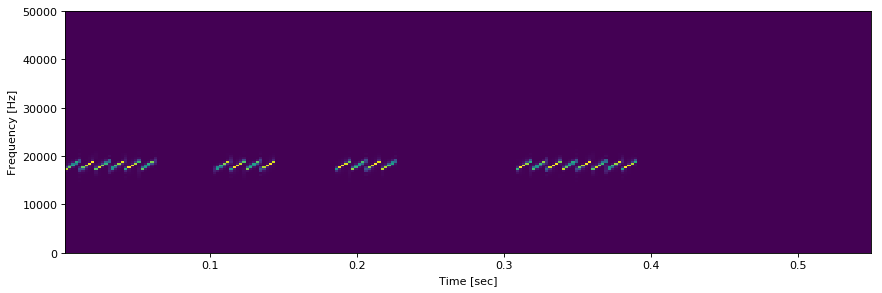

In [109]:
ascii = ord('S')
ASCII_S = list("{0:08b}".format(ascii))

#ASCII_S = [0, 1, 0, 1, 0, 0, 1, 1]

tone = frame(ASCII_S)

#plt.plot(tone)

plt.figure(figsize=(13, 4), dpi=80)
f, t, Sxx = spectrogram(tone, fs=SAMPLING_RATE)
#f, Pxx = welch(tone, fs=SAMPLING_RATE)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [171]:
WAV_FILE = 'ChirpFrameS.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## ASCII codes "Hello World!"

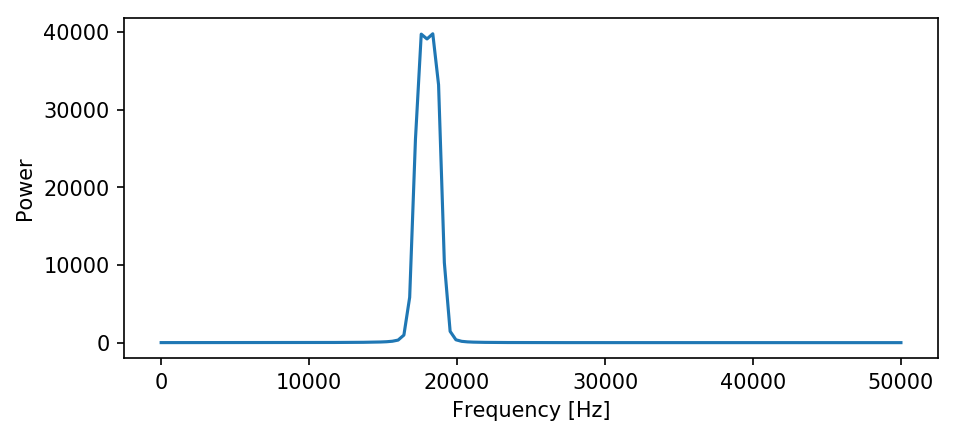

In [114]:
ascii = ord('H')
tone_H = frame(list("{0:08b}".format(ord('H'))))
tone_e = frame(list("{0:08b}".format(ord('e'))))
tone_l = frame(list("{0:08b}".format(ord('l'))))
tone_o = frame(list("{0:08b}".format(ord('o'))))
tone__ = frame(list("{0:08b}".format(ord(' '))))
tone_W = frame(list("{0:08b}".format(ord('W'))))
tone_r = frame(list("{0:08b}".format(ord('r'))))
tone_d = frame(list("{0:08b}".format(ord('d'))))
tone_exc = frame(list("{0:08b}".format(ord('!'))))

tone = tone_H
tone = append(tone, tone_e)
tone = append(tone, tone_l)
tone = append(tone, tone_l)
tone = append(tone, tone_o)
tone = append(tone, tone__)
tone = append(tone, tone_W)
tone = append(tone, tone_o)
tone = append(tone, tone_r)
tone = append(tone, tone_l)
tone = append(tone, tone_d)
tone = append(tone, tone_exc)

plt.figure(figsize=(7, 3), dpi=150)

f, Pxx = welch(tone, fs=SAMPLING_RATE)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.plot(f, Pxx)

WAV_FILE = 'ChirpFrameHelloWorld.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## Repeat

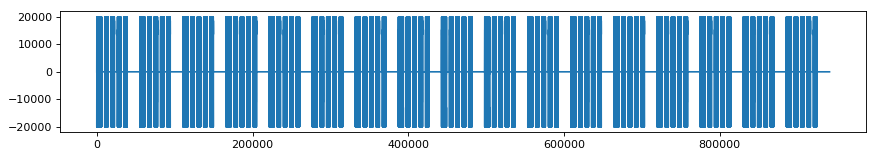

In [173]:
tone = frame([0,1,0,1,0,1,0,1])
for i in range(16):
    tone = append(tone, frame([0,1,0,1,0,1,0,1]))
    
plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameRepeat.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## Constant tone

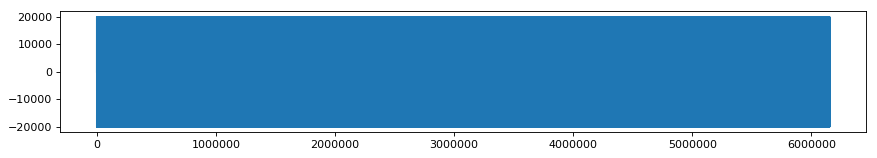

In [174]:
tone = TQ_HIGH;
for i in range(3000):  # approx. 1 min length
    tone = append(tone, TQ_HIGH)
    
plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameConstant.wav'
write(WAV_FILE, SAMPLING_RATE, tone)